In [ ]:
"""
Team Gopher Knowledge:
    Michael Ramsey, University of Colorado
    Hua Chen, University of Delaware
    Aaron Cohen, Indiana University
    Mingchang Ding, University of Delaware
    Melanie Jensen, Tulane University
    Christopher Miller, University of California, Berkeley
    
IMA Intro to Math Bootcamp: 6/1/18 - 7/20/18

Date Created: 6/1/18
Last Edited: 9/25/18

DESCRIPTION:
    This is a Python notebook to investigate the use of variational autoencoders in classifying the MNIST dataset.
    We project the orginal image space down to 50-dimensional latent space. We use this file to create good
    visualizations of latent space and how the digits in relate to each other in latent space.

Much of this code is adapted from: http://pyro.ai/examples/vae.html
"""

## Vairational Autoencoder

The VAE example in the Pyro docs http://pyro.ai/examples/vae.html

Reference: 
* Original paper by Diederik P Kingma, Max Welling: Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114
* Pyro example code of VAE https://github.com/uber/pyro/blob/dev/examples/vae/vae.py

In [1]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [3]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [6]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [7]:
# vae = VAE()
# optimizer = Adam({"lr": 1.0e-3})
# svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [8]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [9]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 101
TEST_FREQUENCY = 5

train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 190.9630
[epoch 000] average test loss: 155.7649
[epoch 001]  average training loss: 146.2289
[epoch 002]  average training loss: 132.9159
[epoch 003]  average training loss: 124.6936
[epoch 004]  average training loss: 119.5353
[epoch 005]  average training loss: 115.9922
[epoch 005] average test loss: 113.8192
[epoch 006]  average training loss: 113.7288
[epoch 007]  average training loss: 112.1366
[epoch 008]  average training loss: 110.9583
[epoch 009]  average training loss: 109.9786
[epoch 010]  average training loss: 109.2059
[epoch 010] average test loss: 108.3574
[epoch 011]  average training loss: 108.5663
[epoch 012]  average training loss: 108.0132
[epoch 013]  average training loss: 107.5487
[epoch 014]  average training loss: 107.0921
[epoch 015]  average training loss: 106.7289
[epoch 015] average test loss: 106.0388
[epoch 016]  average training loss: 106.3730
[epoch 017]  average training loss: 106.1228
[epoch 018]  average training 

## Ploting some results

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

<Figure size 864x576 with 0 Axes>

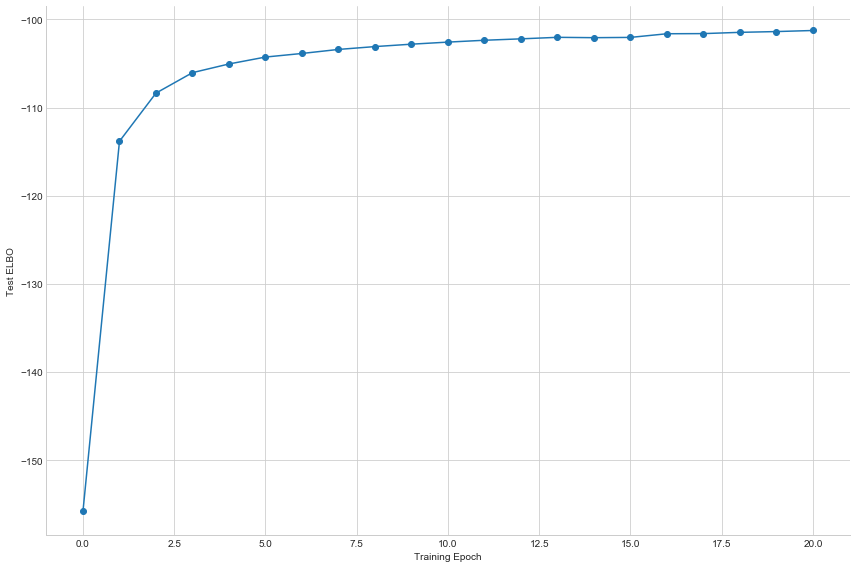

In [11]:
fig = plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
data = np.concatenate([np.arange(len(np.array(test_elbo)))[:, sp.newaxis], 
                       np.array(test_elbo)[:, sp.newaxis]], axis=1)
df = pd.DataFrame(data=data, columns=['Training Epoch', 'Test ELBO'])
g = sns.FacetGrid(df, size=8, aspect=1.5)
g.map(plt.scatter, "Training Epoch", "Test ELBO")
g.map(plt.plot, "Training Epoch", "Test ELBO")

In [12]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

data = test_loader.dataset.test_data.float()
mnist_labels = test_loader.dataset.test_labels
z_loc, z_scale = vae.encoder(data)

from sklearn.manifold import TSNE

model_tsne = TSNE(n_components=2, random_state=0)
z_states = z_loc.detach().cpu().numpy()
print('1')
z_embed = model_tsne.fit_transform(z_states)
print('2')
mnist_labels = mnist_labels.detach().cpu().numpy()

1
2


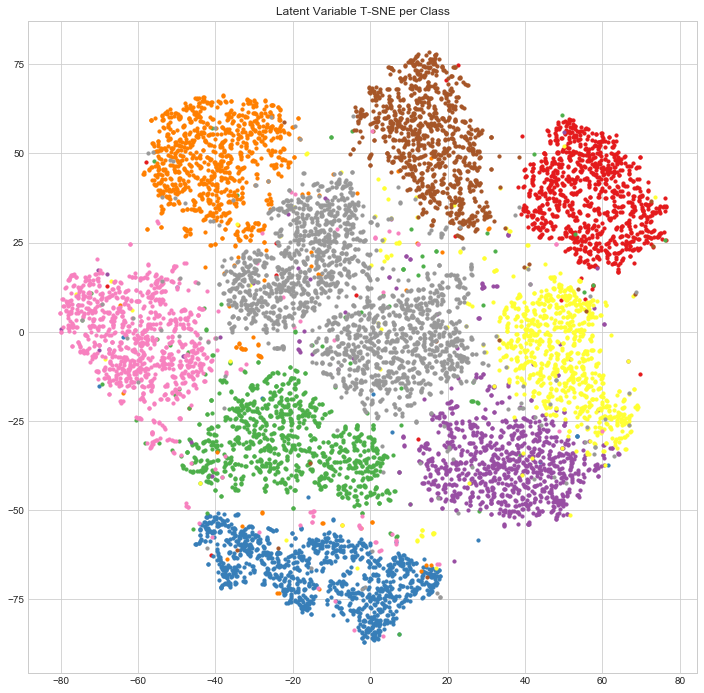

In [13]:
fig = plt.figure(figsize=(12, 12))
for ic in range(10):
#     ind_vec = np.zeros_like(mnist_labels)
#     ind_vec[:, ic] = 1
    ind_class = mnist_labels[:] == ic
    color = plt.cm.Set1(ic)
    plt.scatter(z_embed[ind_class, 0], z_embed[ind_class, 1], s=10, color=color)
    plt.title("Latent Variable T-SNE per Class")
    

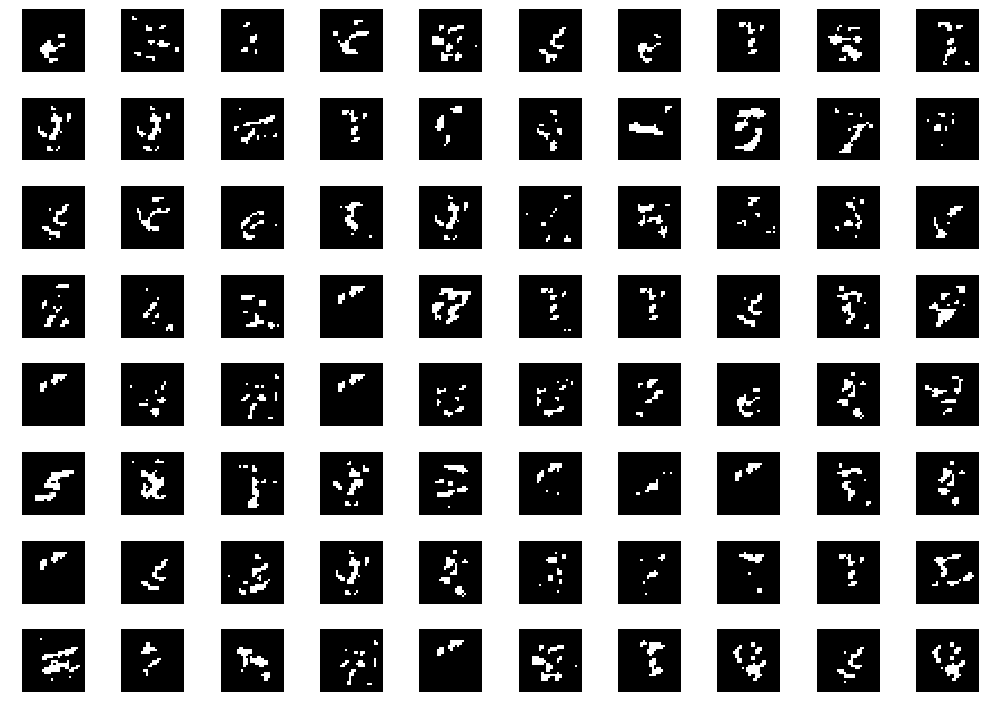

In [14]:
# vae = VAE()
x_sample = data

plt.figure(figsize=(14, 10))

for i in range(80):

    plt.subplot(8, 10, i + 1)
    ind = np.random.randint(0, x_sample.size(0))
#     vae.model(x_sample[ind])
    x_reconstruct = vae.reconstruct_img(x_sample[ind])
    plt.imshow(x_reconstruct.detach().reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.tight_layout()

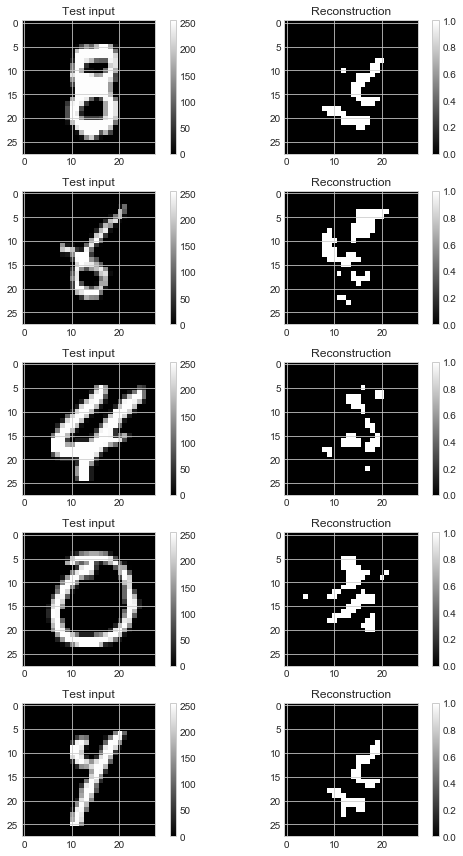

In [38]:
plt.figure(figsize=(8, 12))

for i in range(5):
    ind = np.random.randint(0, x_sample.size(0))
    
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[ind].reshape(28, 28), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    
    plt.subplot(5, 2, 2*i + 2)
    x_reconstruct = vae.reconstruct_img(x_sample[ind])
    plt.imshow(x_reconstruct.detach().reshape(28, 28), cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

In [ ]:
#Makes a list of arrays, each containing the dimension-by-dimension median of the vectors
#of a given class.
medians = []
for z in range(10):
    total = np.zeros([1,50])
    for data in test_loader.dataset:
        if data[1] == z:
            mu, sigma = vae.encoder(data[0])
            total = np.append(total,np.array(mu.detach()),axis=0)
    medians.append(np.array([np.median(total, axis = 0)]))

#Makes a list of arrays, each containing the mean of the vectors of a given class.
centroids = []
for z in range(10):
    total = np.empty([1,50])
    n=0.0
    for data in test_loader.dataset:
        if data[1] == z:
            mu, sigma = vae.encoder(data[0])
            total += np.array(mu.detach())
            n+=1
    print(z,n)
    centroids.append(total/n)

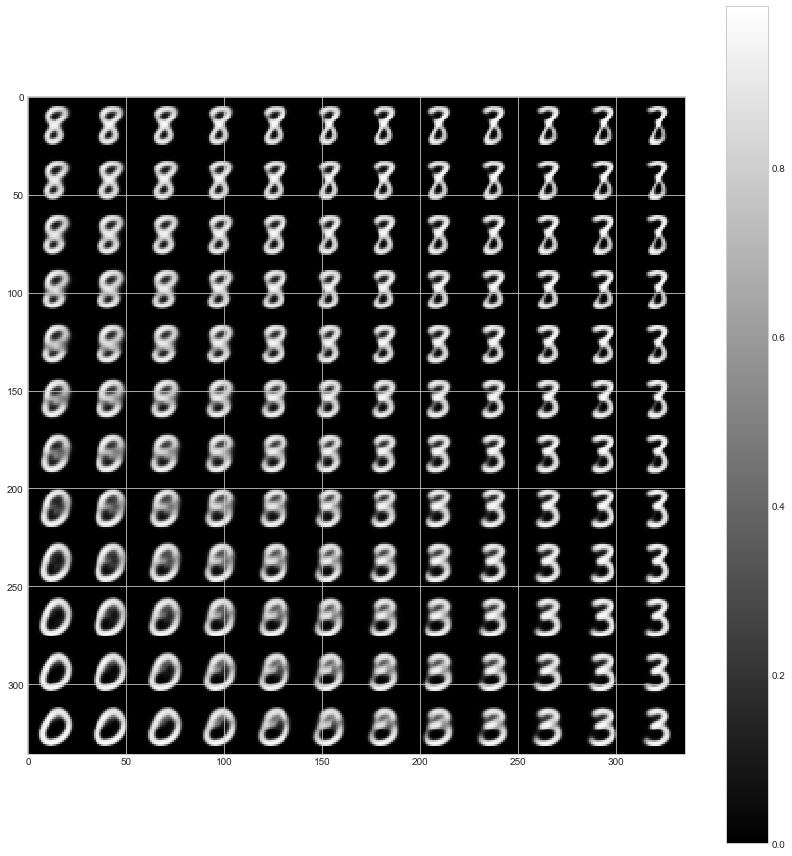

In [207]:
#Chris' attempt to cut out a hyperplane that interpolates between several centroids, medians, etc
batch_size = 256
z_dim = 50
"""
If you want to use spceific samples, you can follow this code
sample0 = x_sample[3]
sample1 = x_sample[7]
sample2 = x_sample[8]

#Gather mu values
origin, z_scale0 = vae.encoder(sample0)
x_end, z_scale1 = vae.encoder(sample1)
y_end, z_scale2 = vae.encoder(sample2)

#Convert to array type
x_end = np.array(x_end.detach())
y_end = np.array(y_end.detach())
origin = np.array(origin.detach())
"""

#Use medians...
origin = medians[0]
y_end = medians[3]
x_end = medians[8]


#Or centoroids. Comment out the other one.
#origin = centroids[0]
#y_end = centroids[3]
#x_end = centoroids[8]



#Compute vectors of interest. These are as numpy arrays.
y_vect = (y_end - origin)
x_vect = (x_end - origin)


#set a grid size
nx = ny = 12
x_values = np.linspace(0.0, 1.0, nx)
y_values = np.linspace(0.0, 1.0, ny)

canvas = np.empty((28*ny, 28*nx))

#Go through and produce the images coming from latent space
for i, xi in enumerate(x_values):
    for j, yi in enumerate(y_values):  
        latent_vect = torch.tensor(list(origin+ x_vect*xi + y_vect*yi)).float()
        x = vae.decoder.forward(latent_vect)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x[0].detach().reshape(28, 28)

#Plot it
plt.figure(figsize=(12, 12))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.colorbar()
plt.tight_layout()


In [178]:
centroids = []
for z in range(10):
    total = np.empty([1,50])
    n=0.0
    for data in test_loader.dataset:
        if data[1] == z:
            mu, sigma = vae.encoder(data[0])
            total += np.array(mu.detach())
            n+=1
    print(z,n)
    centroids.append(total/n)

0 980.0
1 1135.0
2 1032.0
3 1010.0
4 982.0
5 892.0
6 958.0
7 1028.0
8 974.0
9 1009.0


In [199]:
medians = []
for z in range(10):
    total = np.zeros([1,50])
    for data in test_loader.dataset:
        if data[1] == z:
            mu, sigma = vae.encoder(data[0])
            total = np.append(total,np.array(mu.detach()),axis=0)
    medians.append(np.array([np.median(total, axis = 0)]))
            

    

[[ 0.08560502 -0.22366709 -0.01706889  0.21674535 -0.10802293 -0.11526739
   0.05871661 -0.16975786 -0.03822267  0.14114848 -0.04605273  0.07406981
  -0.02681086 -0.38896549 -0.1339833   0.04665415  0.01240677  1.24675852
  -0.56629136 -0.07489486 -0.004762   -0.04056149 -0.07012887  1.5503515
  -0.32658473  0.09572925 -0.03477854  0.07619203  0.01095943  0.05718075
   0.01518564 -0.07057258  0.04193204  0.09572328 -0.08897997  0.04531723
   0.05860038 -0.03414821 -0.07248921  0.17878437 -0.01339856  0.07625762
  -0.07562169 -0.02640405 -0.00439268  0.07397617 -0.87377051 -0.07048199
  -0.00458846  0.02547289]]
[[ 0.3336732  -0.05946102  0.30990237  0.77229051 -0.18711099 -0.17909327
   0.11895861 -0.54683286 -0.04724552  0.05308953 -0.06634228  0.10038135
  -0.03574556 -0.1744846  -0.01208124  0.05493221  0.17084161  1.34428515
   0.03126569  0.44100912 -0.04591099  0.00640442 -0.09377413  1.47100627
  -0.25781448  0.41840625 -0.08367533  0.15058575  0.03155687  0.10516638
  -0.026395